# Camera calibration using CHARUCO

In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg


## 2. Camera pose estimation using CHARUCO chessboard

First, let's create the board.

<IPython.core.display.Javascript object>


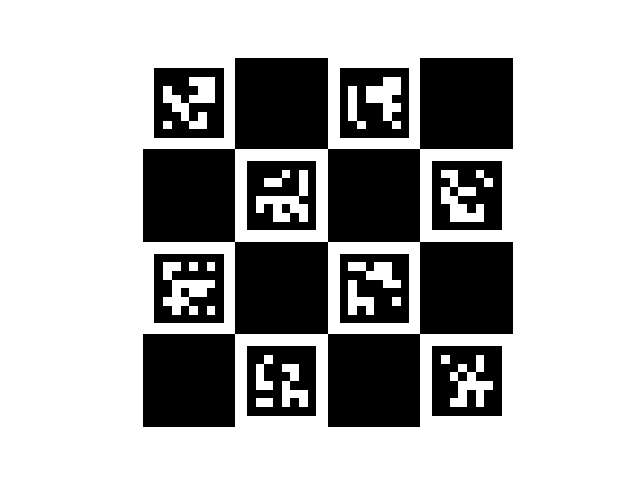

In [2]:
imagesFolder = "./images/"
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
board = aruco.CharucoBoard_create(4, 4, 0.04, 0.03, aruco_dict)
imboard = board.draw((2000, 2000))
cv2.imwrite(imagesFolder + "chessboard.tiff", imboard)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()


And take photos of it from multiple angles, for example:

In [18]:
######### convert video to images ##########
# Settings
videoFile = "videos/camCal.mp4"
# video to images
cap = cv2.VideoCapture(videoFile)
while(cap.isOpened()):
    frameId = cap.get(1)  #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId%5==0):
#         frame = cv2.rotate(frame,cv2.ROTATE_90_CLOCKWISE)
        filename = imagesFolder + "camCal/image_" +  str(int(frameId/5)) + ".jpg"
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [19]:
images = np.array([imagesFolder + 'camCal/'  + f for f in os.listdir(imagesFolder+'camCal/') if f.endswith(".jpg") ])
order = np.argsort([int(p.split(".")[-2].split("_")[-1]) for p in images])
images = images[order]
images

array(['./images/camCal/image_0.jpg', './images/camCal/image_1.jpg',
       './images/camCal/image_2.jpg', './images/camCal/image_3.jpg',
       './images/camCal/image_4.jpg', './images/camCal/image_5.jpg',
       './images/camCal/image_6.jpg', './images/camCal/image_7.jpg',
       './images/camCal/image_8.jpg', './images/camCal/image_9.jpg',
       './images/camCal/image_10.jpg', './images/camCal/image_11.jpg',
       './images/camCal/image_12.jpg', './images/camCal/image_13.jpg',
       './images/camCal/image_14.jpg', './images/camCal/image_15.jpg',
       './images/camCal/image_16.jpg', './images/camCal/image_17.jpg',
       './images/camCal/image_18.jpg', './images/camCal/image_19.jpg',
       './images/camCal/image_20.jpg', './images/camCal/image_21.jpg',
       './images/camCal/image_22.jpg', './images/camCal/image_23.jpg',
       './images/camCal/image_24.jpg', './images/camCal/image_25.jpg',
       './images/camCal/image_26.jpg', './images/camCal/image_27.jpg',
       './images

<IPython.core.display.Javascript object>


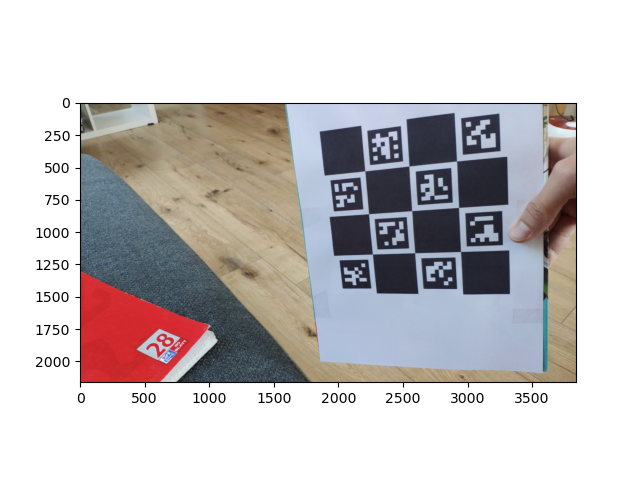

In [20]:
im = PIL.Image.open(images[0])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
#ax.axis('off')
plt.show()


Now, the camera calibration can be done using all the images of the chessboard. Two functions are necessary:

* The first will detect markers on all the images and.
* The second will proceed the detected markers to estimage the camera calibration data.

In [21]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner, 
                                 winSize = (3,3), 
                                 zeroZone = (-1,-1), 
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator+=1

    imsize = gray.shape
    return allCorners,allIds,imsize

In [22]:
allCorners,allIds,imsize=read_chessboards(images)
imsize

POSE ESTIMATION STARTS:
=> Processing image ./images/camCal/image_0.jpg
=> Processing image ./images/camCal/image_1.jpg
=> Processing image ./images/camCal/image_2.jpg
=> Processing image ./images/camCal/image_3.jpg
=> Processing image ./images/camCal/image_4.jpg
=> Processing image ./images/camCal/image_5.jpg
=> Processing image ./images/camCal/image_6.jpg
=> Processing image ./images/camCal/image_7.jpg
=> Processing image ./images/camCal/image_8.jpg
=> Processing image ./images/camCal/image_9.jpg
=> Processing image ./images/camCal/image_10.jpg
=> Processing image ./images/camCal/image_11.jpg
=> Processing image ./images/camCal/image_12.jpg
=> Processing image ./images/camCal/image_13.jpg
=> Processing image ./images/camCal/image_14.jpg
=> Processing image ./images/camCal/image_15.jpg
=> Processing image ./images/camCal/image_16.jpg
=> Processing image ./images/camCal/image_17.jpg
=> Processing image ./images/camCal/image_18.jpg
=> Processing image ./images/camCal/image_19.jpg
=> Pro

(2160, 3840)

In [23]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
#     cameraMatrixInit = np.array([[ 3000.,    0., imsize[0]/2.],
#                                  [    0., 3000., imsize[1]/2.],
#                                  [    0.,    0.,           1.]])
    cameraMatrixInit = np.array([[ 2950.,    0., imsize[1]/2.],
                                 [    0., 2950., imsize[0]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
#     flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO) 
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS)
    #flags = (cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))
#     (ret, camera_matrix, distortion_coefficients0, 
#      rotation_vectors, translation_vectors) = cv2.aruco.calibrateCameraCharuco(
#                       charucoCorners=allCorners,
#                       charucoIds=allIds,
#                       board=board,
#                       imageSize=imsize,
#                       cameraMatrix = None,
#                       distCoeffs = None)

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [24]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
Wall time: 37.2 s


In [25]:
ret

1.323455684771432

In [26]:
mtx

array([[3.01535570e+03, 0.00000000e+00, 1.94592662e+03],
       [0.00000000e+00, 3.00964205e+03, 1.09600251e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [27]:
dist

array([[ 4.02904496e-01],
       [-1.95167386e+00],
       [ 1.14334467e-03],
       [-2.71652874e-04],
       [ 3.00579817e+00]])

In [28]:
np.savetxt("camCalMtx.csv", mtx)
np.savetxt("camCalDist.csv", dist)

In [24]:
mtx = np.loadtxt("camCalMtx.csv")
dist = np.loadtxt("camCalDist.csv")

### Check calibration results

<IPython.core.display.Javascript object>


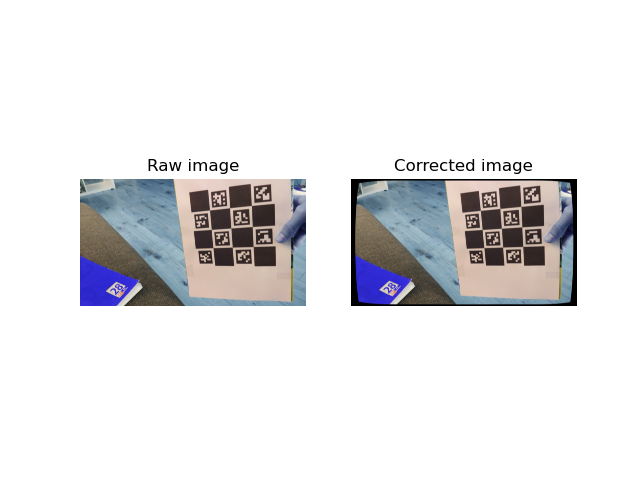

In [29]:
i=0 # select image id
plt.figure()
frame = cv2.imread(images[i])
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

## 3 . Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

<IPython.core.display.Javascript object>


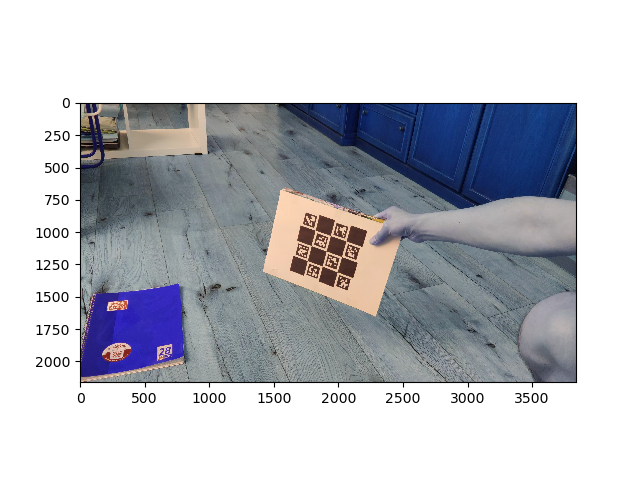

In [15]:

frame = cv2.imread(images[0])
# frame = cv2.imread('images/pos1.jpg')
#frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure()
plt.imshow(frame, interpolation = "nearest")
plt.show()

## Post processing

In [16]:

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, 
                                                      parameters=parameters)
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)
    
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

corners

[array([[[2005.6165, 1334.5549],
         [2094.7573, 1367.5835],
         [2069.9934, 1453.1912],
         [1981.5958, 1419.3545]]], dtype=float32),
 array([[[1774.1698, 1247.3302],
         [1859.3505, 1278.4629],
         [1836.5215, 1363.0219],
         [1752.1122, 1331.52  ]]], dtype=float32),
 array([[[1920.706 , 1173.9336],
         [2008.6531, 1205.3928],
         [1983.6516, 1293.227 ],
         [1897.4573, 1260.4021]]], dtype=float32),
 array([[[2074.0056, 1096.0251],
         [2165.2573, 1128.1729],
         [2138.1375, 1218.8058],
         [2047.8959, 1186.0242]]], dtype=float32),
 array([[[1690.0343, 1090.3259],
         [1774.5515, 1120.6481],
         [1752.0739, 1207.0922],
         [1669.2175, 1176.1014]]], dtype=float32),
 array([[[1834.7014 , 1012.61456],
         [1921.8339 , 1042.583  ],
         [1897.8414 , 1131.9292 ],
         [1811.681  , 1101.1823 ]]], dtype=float32),
 array([[[1986.1864 ,  932.2522 ],
         [2076.9778 ,  962.50653],
         [2050.9175 , 

Very fast processing !

## Results

<IPython.core.display.Javascript object>


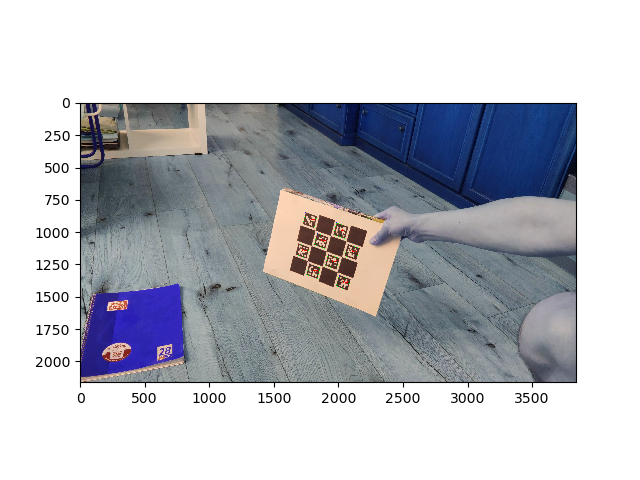

In [17]:
plt.figure()
plt.imshow(frame_markers, interpolation = "nearest")

plt.show()

### Add local axis on each marker

In [69]:
size_of_marker =  0.015 # side lenght of the marker in meter
rvecs,tvecs,trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

In [70]:
length_of_axis = 0.015
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

<IPython.core.display.Javascript object>


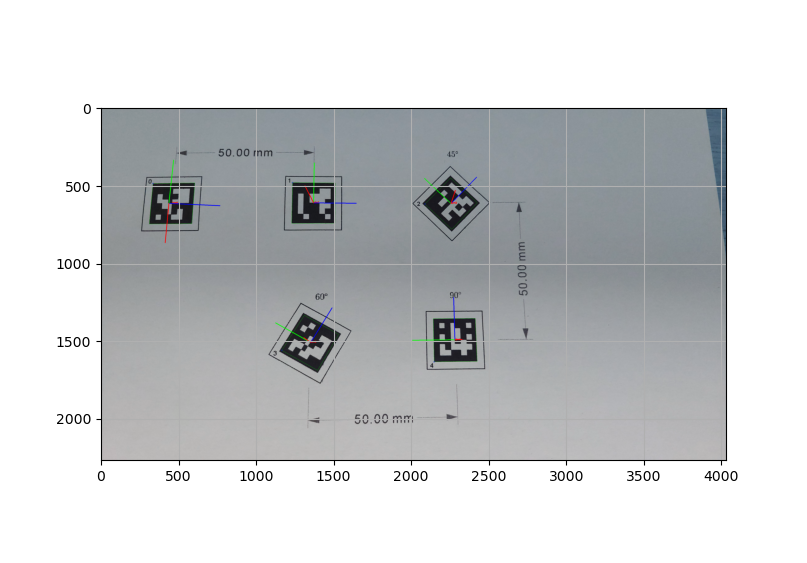

In [71]:
plt.figure()
plt.imshow(imaxis)
plt.grid()
plt.show()

In [72]:
refID = 0
checkID = 3
if refID in ids:
    idx = np.where(ids == refID)
    rRefMtx,_jacob = cv2.Rodrigues(rvecs[idx])
    tRefVec = tvecs[idx][0]

        

data = pd.DataFrame(data = (tvecs-tRefVec).reshape(len(tvecs),3)@rRefMtx, columns = ["tx", "ty", "tz"], 
                    index = ids.flatten())
# data = pd.DataFrame(data = tvecs.reshape(len(tvecs),3), columns = ["tx", "ty", "tz"], 
#                     index = ids.flatten())
data.index.name = "marker"
data.sort_index(inplace= True)
data

,tx,ty,tz
marker,,,
0,0.000000,0.000000,0.000000
1,0.048029,-0.017297,-0.025321
2,0.104011,-0.014124,-0.029140
3,0.049420,-0.055977,0.008073
4,0.092294,-0.028902,0.027383


In [73]:
for ID in ids:
    idx = np.where(ids == ID)
    rMtx,_jacob = cv2.Rodrigues(rvecs[idx])
    tVec = tvecs[idx][0]
    if(ID[0]):
        print("ID = {0}".format(ID[0]))
        print(np.rad2deg(np.arccos(rRefMtx.T@rMtx@[1,0,0]@[1,0,0])))

ID = 4
88.79837583463639
ID = 3
58.90346551972094
ID = 1
24.16572328133747
ID = 2
47.89389511248185


In [48]:
datar = pd.DataFrame(data = tvecs.reshape(len(rvecs),3), columns = ["rx", "ry", "rz"], 
                    index = ids.flatten())
datar.index.name = "marker"
datar.sort_index(inplace= True)
np.degrees(datar)


,rx,ry,rz
marker,,,
1,-2.799254,-0.852088,12.187810
2,-0.642999,-2.143169,13.611593
3,-0.969296,0.702478,10.709314
4,1.216634,-0.589658,12.282365


In [99]:
v = data.loc[3:6].values
((v[1:] - v[:-1])**2).sum(axis = 1)**.5

array([0.12683144, 0.08000447, 0.05686347])

In [100]:
cv2.Rodrigues(rvecs[0], np.zeros((3,3)))

(array([[ 0.99965498, -0.02460829, -0.00918395],
        [-0.02594447, -0.97964369, -0.1990606 ],
        [-0.00409845,  0.1992302 , -0.97994415]]),
 array([[ 1.99895632e-04,  2.53553591e-03,  1.49643124e-02,
          9.56381481e-03, -1.99332388e-01,  9.79734735e-01,
         -1.17852889e-02, -9.79832994e-01, -1.99158309e-01],
        [ 1.71873960e-02,  6.73007793e-01,  6.74974433e-02,
          6.72918054e-01, -1.46448144e-02, -1.56324453e-02,
         -6.75957025e-02,  1.11171559e-02,  2.54291131e-03],
        [ 4.51587340e-03, -6.77546867e-02,  6.73092133e-01,
          6.76564275e-02,  6.68716943e-04, -1.21089488e-02,
          6.73181872e-01, -5.08066991e-03, -3.84841106e-03]]))

<IPython.core.display.Javascript object>


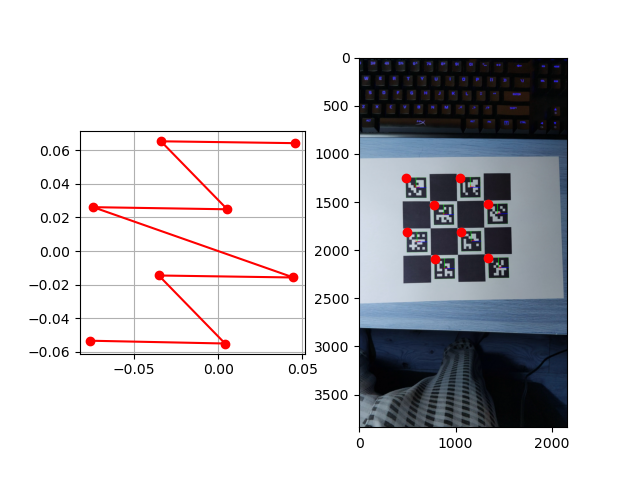

In [101]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(1,2,1)
ax.set_aspect("equal")
plt.plot(data.tx, data.ty, "or-")
plt.grid()
ax = fig.add_subplot(1,2,2)
plt.imshow(imaxis, origin = "upper")
plt.plot(np.array(corners)[:, 0, 0,0], np.array(corners)[:, 0, 0,1], "or")
plt.show()

In [102]:
a = np.arange(50)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [103]:
import pickle

In [104]:
f = open("truc.pckl", "wb")
pickle.dump(a, f)
f.close()

In [105]:
f = open("truc.pckl", "rb")
b = pickle.load(f)
b == a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [106]:
corners = np.array(corners)
data2 = pd.DataFrame({"px": corners[:, 0, 0, 1], 
                      "py": corners[:, 0, 0, 0]}, index = ids.flatten())
data2.sort_index(inplace=True)
data2

,px,py
0,1250.625244,484.511108
1,1247.280273,1049.653931
2,1531.825562,774.087341
3,1525.394287,1332.122314
4,1815.451294,494.302582
5,1808.953003,1058.423096
6,2092.167236,782.467285
7,2082.624268,1341.546509


In [107]:
m0 = data2.loc[0]
m43 = data2.loc[43]
d01 = ((m0 - m43).values**2).sum()**.5
d = 42.5e-3 * (3.5**2 + 4.5**2)**.5
factor = d / d01
data2["x"] = data2.px * factor
data2["y"] = data2.py * factor
((data2[["x", "y"]].loc[11] - data2[["x", "y"]].loc[0]).values**2).sum()**.5


KeyError: 43

In [347]:

c = np.array(corners).astype(np.float64).reshape(44,4,2)
(((c[:, 1:] - c[:, :-1])**2).sum(axis = 2)**.5).mean(axis =1)

array([ 138.33575835,  143.00113377,  142.012097  ,  140.69699432,
        146.66782406,  144.02442319,  138.67845434,  142.33812925,
        143.00229095,  140.33926025,  140.35356753,  146.66786569,
        139.34054504,  146.67222201,  140.03570454,  148.01939184,
        143.35647769,  142.67236143,  147.01931296,  148.02127735,
        137.67392157,  135.35308209,  141.00354688,  143.67946992,
        137.67149733,  138.67392207,  145.00112611,  142.33454105,
        138.3466791 ,  143.00234925,  139.0035972 ,  143.00115739,
        143.6865917 ,  144.67964727,  144.33446711,  141.67253496,
        143.67117097,  147.67232772,  150.35663387,  141.70034559,
        149.01342342,  146.01949591,  144.34013329,  150.35333222])

In [343]:
c

array([[[ 2406.,  1940.],
        [ 2546.,  1940.],
        [ 2545.,  2075.],
        [ 2405.,  2076.]],

       [[ 1991.,  1938.],
        [ 2138.,  1939.],
        [ 2138.,  2076.],
        [ 1993.,  2076.]],

       [[ 1584.,  1936.],
        [ 1728.,  1936.],
        [ 1731.,  2073.],
        [ 1586.,  2072.]],

       [[ 2619.,  1735.],
        [ 2759.,  1735.],
        [ 2754.,  1878.],
        [ 2615.,  1877.]],

       [[ 2198.,  1734.],
        [ 2347.,  1734.],
        [ 2346.,  1878.],
        [ 2199.,  1878.]],

       [[  973.,  1733.],
        [ 1117.,  1731.],
        [ 1121.,  1874.],
        [  976.,  1875.]],

       [[  572.,  1732.],
        [  710.,  1732.],
        [  713.,  1874.],
        [  577.,  1873.]],

       [[ 2410.,  1533.],
        [ 2554.,  1533.],
        [ 2552.,  1672.],
        [ 2408.,  1672.]],

       [[ 1373.,  1326.],
        [ 1519.,  1325.],
        [ 1519.,  1463.],
        [ 1374.,  1464.]],

       [[ 1785.,  1326.],
        [ 1926.,  13

In [11]:
help(cv2.aruco.detectMarkers)

Help on built-in function detectMarkers:

detectMarkers(...)
    detectMarkers(image, dictionary[, corners[, ids[, parameters[, rejectedImgPoints]]]]) -> corners, ids, rejectedImgPoints



(480, 640, 3)